In [162]:
# Second generation video processing:
## List of imports (keep it simple)
import numpy as np
import scipy 
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import subprocess
import tensorflow as tf
from PIL import Image,ImageDraw
import sys

/Users/taigaabe/anaconda3/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [174]:
## In order to set up numerical integration, we need a callable function that calculates derivatives of the movement
## as a set of first order differential equations. Thus we define the following

## Define a form on forces as an external effect (we need a form that will return a value for non-integer evaluated 
## points in t):

def ball(y,t,env_params,dyn_params,ball_params,F):
    
    # Define Effect of forces
    # We have the forces determined as Fx and Fy, a sequence that the input gets to see
    # Determine effect of forces:
    F_vec = np.zeros((4))
    F_vec[3] -= dyn_params['grav_constant']*ball_params['mass'] ## Effect of gravity
    F_vec[2:4] += F(t) ## Deterministic exterior force being applied
    
    ## We want elasticity: 
    if np.any(abs(y[0:2])>env_params['movement_range']):
        F_imp = dyn_params['elasticity']*(abs(y[0:2])>env_params['movement_range'])*100000 ## Bounce back
        F_elast = F_imp*-np.sign(y[0:2])
  
    else:
        F_elast = np.zeros((2))
    F_vec[2:4] += F_elast
    
    ## F = ma
    a_vec = F_vec/ball_params['mass']
    
    ## Write down the full dynamics equation:
    ydot = np.dot(y,dyn_params['dyn_matrix'])+a_vec

    return ydot

## Turn the above into a function. 
## Inputs:
# imsize: width or height of image
# nb_w: number of plane waves to use per color channel (rgb)
# nb_knobs: dimensionality for the low-d parametrization of images
# nb_knobset: number of samples to take of those parameter values (sampled random uniform)
# alpha: overall scaling factor on sampled parameters (knobs)
# beta: additive constant for sampled parameters (knobs)

## Outputs:
## images: (nb_knobset images of shape(imsize,imsize,3))
## knobs: the settings of parameters that generated these images.
def imgen(imsize=64,nb_w = 50,nb_knobs = 2,nb_knobset = 30,alpha = 5,beta = 0,knobs = None,loading = None):
    ## Define xx and yy grids that will make functions easier to define
    x = np.linspace(0,10,imsize)
    y = np.linspace(0,10,imsize)

    xx,yy = np.meshgrid(x,y)
    
    ## Define lambda function that takes you from parameter space into plane waves:
    
    ## This is like sampling points randomly in 2-d fourier space, and then looking at the corresponding images. 
    
    ## Each element of the fourier series that we consier is a "plane wave" that is characterized by four parameters. 
    ## These parameters are: 
    ## 1. Amplitude: given a hard limit of 0,1, we rescale all amplitudes to be centered on 0.5 with corresponding baseline 
    ## amplitude, the parameter here is a scale that varies plane wave amplitudes relative to one another.
    ## 2. Phase: this parameter just describes the shift of the plane wave phase relative to some baseline. 
    ## 3. Period: multiply by some factor of two pi. otherwise unconstrained. 
    ## 4. Angle: a scalar value that determines the degree to which the plane wave varies in the x and y direction. the angle 
    ## should be transformed as sin and cosine to ensure uniformity in some sense 
    
    wave = lambda params: params[0]*np.sin(params[2]*(np.sin(params[3])*xx+np.cos(params[3])*yy+params[1]+0.5))

    ## Define a loading matrix to transform our low-d thing into parameters for a set of waves
    if loading is not None:
        loading_matrix = loading
    else:
        loading_matrix = np.random.uniform(size = (4,nb_knobs,3*nb_w))
    
    ## If the values of the parameters are given, use those. If not, generate from uniform (scaled appropriately)
    if knobs is not None:
        params = knobs
    else: 
        params = alpha*np.random.uniform(size = (nb_knobset,nb_knobs))+beta#np.linspace(0,10,nb_knobset*nb_knobs).reshape(nb_knobset,nb_knobs)
    
    params_transformed = np.dot(params,loading_matrix)
    
    ## Now iterate through plane waves, collapse into channels, normalize and collapse into images.
    allind = range(nb_knobset)
    all_images = []
    for i in allind:
        relevant_params = params_transformed[i,:,:]
        grids = np.array([wave(relevant_params[:,i]) for i in range(3*nb_w)])
        ## Now split into channels:
        channelcomponents = np.split(grids,3,axis = 0)
        ## Now collapse each:
        channels = [np.sum(channelcomp,axis = 0)/float(nb_w) for channelcomp in channelcomponents]
        ## Now normalize each:
        normchannels = [(channel-np.min(channel))/(np.max(channel)-np.min(channel)) for channel in channels]
        ## combine into an image:
        image = np.stack(normchannels,axis = -1)
        all_images.append(image)
    return all_images,params,loading_matrix

## Designate helper function to define features for examples more easily
def _int64_feature_(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature_(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature_(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))



def _encoder_example_as_writing(videoname,frame,i,params,pos):
    features = {'video': _bytes_feature_(tf.compat.as_bytes((videoname))),
                'frame': _int64_feature_(i),
                'image': _bytes_feature_(tf.compat.as_bytes(frame.tostring())),
                'intensity':_float_feature_(1),
                'background':_bytes_feature_(tf.compat.as_bytes(params.tostring())),
                'position':_bytes_feature_(tf.compat.as_bytes(pos.tostring()))
                }
    example = tf.train.Example(features = tf.train.Features(feature = features))
    return example

In [175]:
## List of parameters
m = 10.0 # mass of ball
r = 6 # radius of ball

ball_params = {'mass':m,'radius':r}

dim = 2 #dimensionality of the problem
g = 0 #m/(s^2) (gravitational constant)
mv_range = 26 # given as a radius
d = mv_range+ball_params['radius'] # size of a square enclosure
t = 500 # time to simulate for ('seconds')
dt = 5000 # steps per second
# w = 20
# h = 20
dpi = 4
nb_backgrounds = 10
env_params = {'dimension':dim,
              'grav_constant':g,
              'enclosure_size':d,
              'movement_range':mv_range,
              'simtime':t,
              'timesteps':dt*t,
              'dpi':dpi}


A = np.zeros((4,4))
A[2,0] = 1
A[3,1] = 1 ## dynamics matrix
e = 1 ## reduction in force 
dyn_params = {'grav_constant':g,'dyn_matrix':A,'elasticity':e}



In [176]:
backgrounds,params,loadmat = imgen(imsize = 2*env_params['enclosure_size'],nb_knobset = nb_backgrounds)

In [177]:
## Solve for given F,y0,t
F = lambda t: np.array([-5*np.sin(t),5*np.cos(t/5.)-1])
# F = lambda t: np.array([10*np.sin(t/5.),10*np.cos(t/6.)])
# F = lambda t: np.array([0,0])
y0 = np.zeros((4))
y0[2]-= (1./3)/10
y0[0]-=20
t = np.linspace(0,nb_backgrounds*env_params['simtime'],env_params['timesteps'])
sol = odeint(ball, y0, t, args=(env_params,dyn_params,ball_params,F))

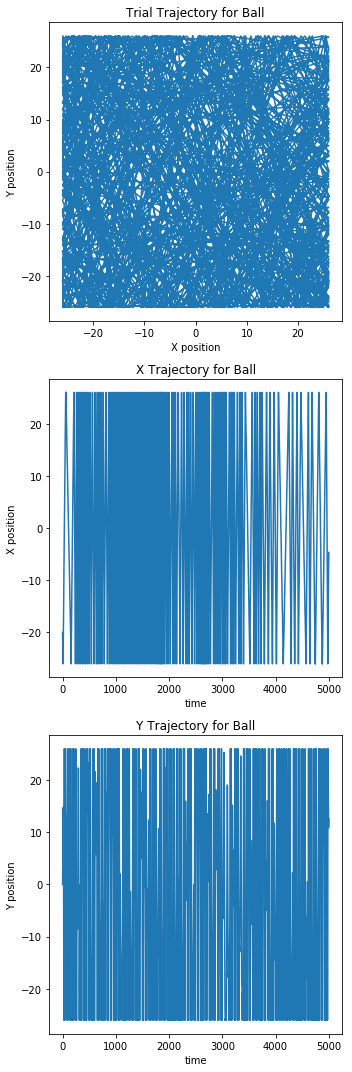

In [178]:
fig,ax = plt.subplots(3,1,figsize = (5,15))
ax[0].plot(sol[:,0],sol[:,1])
ax[0].set_title('Trial Trajectory for Ball')
ax[0].set_xlabel('X position')
ax[0].set_ylabel('Y position')
ax[1].plot(t,sol[:,0])
ax[1].set_title('X Trajectory for Ball')
ax[1].set_xlabel('time')
ax[1].set_ylabel('X position')
ax[2].plot(t,sol[:,1])
ax[2].set_title('Y Trajectory for Ball')
ax[2].set_xlabel('time')
ax[2].set_ylabel('Y position')
plt.tight_layout()
plt.show()

In [186]:
all_datadirect = 'datadirectory'
try:
    os.mkdir(all_datadirect)
except:
    print('all data directory already exists!')

videodirectory = 'toydynamics_nograv'
try:
    os.mkdir(all_datadirect+'/'+videodirectory)
except:
    print('Directory already exists!')
# Sample at the seconds timescale:
frames = np.linspace(0,env_params['timesteps']-1,nb_backgrounds*env_params['simtime']).astype('int')
print('Generating Frames')

# Preprocess 
# sol[sol>(env_params['movement_range']-0.5)]=env_params['movement_range']-0.5
# sol[sol<(-env_params['movement_range']+0.5)]=-env_params['movement_range']+0.5
background = np.zeros((2*env_params['enclosure_size'],2*env_params['enclosure_size'],3)).astype(np.uint8)




## Now simulate and write:

datafile_name = "colorback_real.tfrecords"


writer = tf.python_io.TFRecordWriter(datafile_name)
for i,ti in enumerate(frames):
    j = i/500
    bias = env_params['enclosure_size']
    img = Image.fromarray(((255*backgrounds[j]).astype(np.uint8)))  
    draw = ImageDraw.Draw(img)
    print(sol[ti,0])
    draw.ellipse((sol[ti,0]-ball_params['radius']+bias, sol[ti,1]-ball_params['radius']+bias, sol[ti,0]+ball_params['radius']+bias, sol[ti,1]+ball_params['radius']+bias), fill=(255,255,255,255))# Create a PIL image
    img.save(all_datadirect+'/'+videodirectory+'/'+'colorframe%04d.png'%i)
    frame = np.array(img.getdata()).reshape(img.size[0], img.size[1], 3)/255.
    print(frame[32,32,0])
    example = _encoder_example_as_writing(datafile_name,frame,i,params[j,:],sol[ti,:])
    writer.write(example.SerializeToString())
writer.close()
sys.stdout.flush()

all data directory already exists!
Directory already exists!
Generating Frames
-20.0
0.09803921568627451
-20.11259793033879
0.09803921568627451
-20.61201850326046
0.09803921568627451
-21.529441146643183
0.09803921568627451
-22.511735875871313
0.09803921568627451
-23.14612949780708
0.09803921568627451
-23.339707740516786
0.09803921568627451
-23.40484024634034
0.09803921568627451
-23.771989158479133
0.09803921568627451
-24.59394398846971
0.09803921568627451
-25.605347483077498
0.09803921568627451
-25.49738906314611
0.09803921568627451
-24.223955993223882
0.09803921568627451
-22.70463959695046
0.09803921568627451
-21.379309173164625
0.09803921568627451
-20.50948422621499
0.09803921568627451
-19.937894231586736
0.09803921568627451
-19.23307261865274
0.09803921568627451
-18.086045518985443
0.09803921568627451
-16.5944010105841
0.09803921568627451
-15.172567043244062
0.09803921568627451
-14.169256573091495
0.09803921568627451
-13.552029871116241
0.09803921568627451
-12.928891560291015
0.0980

7.688596700944761
0.09803921568627451
5.857517007267689
1.0
4.446142219136151
1.0
3.103727678520627
1.0
1.416127072542044
1.0
-0.7134432420548187
1.0
-2.9754217292736485
1.0
-4.941959480396841
1.0
-6.448890221701329
0.09803921568627451
-7.763449580667158
0.09803921568627451
-9.325393782520047
0.09803921568627451
-11.347034425600969
0.09803921568627451
-13.61804000521532
0.09803921568627451
-15.698813849316279
0.09803921568627451
-17.324657442078966
0.09803921568627451
-18.649133494846907
0.09803921568627451
-20.102880925100933
0.09803921568627451
-22.00192839605356
0.09803921568627451
-24.244406383224227
0.09803921568627451
-25.56373764108667
0.09803921568627451
-23.14996864747937
0.09803921568627451
-20.350341569341523
0.09803921568627451
-17.552494438110628
0.09803921568627451
-15.142428429531568
0.09803921568627451
-13.149620614371715
0.09803921568627451
-11.219922719289203
0.09803921568627451
-8.94116318560412
0.09803921568627451
-6.216378832218475
0.09803921568627451
-3.3707867859

0.09803921568627451
3.4505198028635964
0.09803921568627451
5.795125592289458
0.09803921568627451
8.554226856110871
0.09803921568627451
11.704553295548742
0.09803921568627451
14.863143994269782
0.09803921568627451
17.63943973621494
0.09803921568627451
19.994361727609014
0.09803921568627451
22.27624061361121
0.09803921568627451
24.906297442285684
0.09803921568627451
24.158425527943987
0.09803921568627451
21.29852734950256
0.09803921568627451
18.142188604807526
0.09803921568627451
14.530033469343
0.09803921568627451
10.721761703123486
0.09803921568627451
7.1573818969919225
0.09803921568627451
4.05266936418635
0.09803921568627451
1.2007831646730982
0.09803921568627451
-1.8375653003299628
0.09803921568627451
-5.337641183537616
0.09803921568627451
-9.134995484616905
0.09803921568627451
-12.806164948578507
0.09803921568627451
-16.037192317293233
0.09803921568627451
-18.918785258381874
0.09803921568627451
-21.862920273109896
0.09803921568627451
-25.224072541737396
0.09803921568627451
-23.18512

0.6
13.953829888816262
0.6
10.99708473340714
0.6
8.492738394711932
0.6
6.282019435354687
0.6
3.9255971691605485
0.6
1.1235727188893712
0.6
-2.0142678947142882
0.6
-5.069390652901185
0.6
-7.699312042145831
0.6
-9.952476948773832
0.6
-12.223718735792419
0.6
-14.891250848528948
0.6
-17.97529915761676
0.6
-21.099541075691004
0.6
-23.863762976075417
0.6
-25.80775899911193
0.6
-23.617624713458028
0.6
-21.74356955135825
0.6
-20.321167592332355
0.6
-19.070744950949248
0.6
-17.554510358649228
0.6
-15.57905863397595
0.6
-13.368846036414865
0.6
-11.373994258112512
0.6
-9.836818431992656
0.6
-8.583167339753336
0.6
-7.17821837456037
0.6
-5.326251535884427
0.6
-3.1425332347535178
0.6
-1.047341204997068
0.6
0.620437824545319
0.6
1.9148787247611048
1.0
3.2362604771587273
1.0
4.95489614747409
0.6
7.080557879072163
0.6
9.246345157624358
0.6
11.048466177627237
0.6
12.417482494597335
0.6
13.68215031994965
0.6
15.267163754876867
0.6
17.302692388596554
0.6
19.50470318671131
0.6
21.439494449842346
0.6
22.911

0.9254901960784314
5.329137562086486
0.9254901960784314
8.797530319815316
0.9254901960784314
12.483663218287354
0.9254901960784314
15.953240296408389
0.9254901960784314
18.956721891760946
0.9254901960784314
21.68824967032374
0.9254901960784314
24.58471128631318
0.9254901960784314
24.214758448604368
0.9254901960784314
21.23934978681772
0.9254901960784314
18.161210521501364
0.9254901960784314
14.65052643750278
0.9254901960784314
10.775163169733316
0.9254901960784314
6.938270933373818
0.9254901960784314
3.5012477922880425
0.9254901960784314
0.4716393224991544
0.9254901960784314
-2.532328477880339
0.9254901960784314
-5.908662988006399
0.9254901960784314
-9.713019023170082
0.9254901960784314
-13.60753026452706
0.9254901960784314
-17.17144186760877
0.9254901960784314
-20.287950941970802
0.9254901960784314
-23.251594840868076
0.9254901960784314
-25.515936960435948
0.9254901960784314
-22.39868976920753
0.9254901960784314
-19.499807470150877
0.9254901960784314
-16.371944046298218
0.925490196078

0.9254901960784314
16.818638106960304
0.9254901960784314
13.458355398774806
0.9254901960784314
9.773597927520761
0.9254901960784314
6.187538777299602
0.9254901960784314
3.0326083803754
0.9254901960784314
0.23940711512462173
0.9254901960784314
-2.5832159782220923
0.9254901960784314
-5.810577146508082
0.9254901960784314
-9.440031514732683
0.9254901960784314
-13.099251423457213
0.9254901960784314
-16.388542752197598
0.9254901960784314
-19.248322264901375
0.9254901960784314
-22.01389829330932
0.9254901960784314
-25.10718943577243
0.9254901960784314
-23.555190148893747
0.9254901960784314
-20.334412047672167
0.9254901960784314
-16.840395907607267
0.9254901960784314
-12.888272357606203
0.9254901960784314
-8.720790172500644
0.9254901960784314
-4.778696840268677
1.0
-1.2955186073784124
1.0
1.9171425574753607
0.9254901960784314
5.296397214099777
0.9254901960784314
9.126190405404506
0.9254901960784314
13.276243798297468
0.9254901960784314
17.329543298239855
0.9254901960784314
20.94104137456655
0.

0.38823529411764707
20.776514089895663
0.38823529411764707
17.37504354217398
0.38823529411764707
13.5153534566136
0.38823529411764707
9.377090881463507
0.38823529411764707
5.396021521895902
0.38823529411764707
1.8633879134415088
0.38823529411764707
-1.348207433849804
0.38823529411764707
-4.648734972364938
0.38823529411764707
-8.37926557360504
0.38823529411764707
-12.47890120203336
0.38823529411764707
-16.547390232879085
0.38823529411764707
-20.213117073787412
0.38823529411764707
-23.47476415669524
0.38823529411764707
-25.31612574517143
0.38823529411764707
-22.341346090347024
0.38823529411764707
-19.797533445351934
0.38823529411764707
-17.346860642888412
0.38823529411764707
-14.575568248807466
0.38823529411764707
-11.35524301442152
0.38823529411764707
-7.975145165267019
0.38823529411764707
-4.871429241592603
1.0
-2.2261452344509673
1.0
0.2001373284117247
1.0
2.8481979782073106
1.0
5.954914313087649
1.0
9.335477731592217
0.38823529411764707
12.559323761620968
0.38823529411764707
15.32653

3.014198293192555
1.0
-0.30544669054032597
1.0
-4.066487373001693
0.38823529411764707
-8.157164290749646
0.38823529411764707
-12.156328902820164
0.38823529411764707
-15.726968965973207
0.38823529411764707
-18.926055762581537
0.38823529411764707
-22.15216561602949
0.38823529411764707
-25.779029291516462
0.38823529411764707
-22.47610157837498
0.38823529411764707
-18.764895178886256
0.38823529411764707
-14.680086882702193
0.38823529411764707
-10.170896113337639
0.38823529411764707
-5.560324700265249
0.38823529411764707
-1.2722756174498828
0.38823529411764707
2.5658739417065517
0.38823529411764707
6.240382693540105
0.38823529411764707
10.187960010556273
0.38823529411764707
14.5942571923294
0.38823529411764707
19.223179996840024
0.38823529411764707
23.633953208911574
0.38823529411764707
24.34137016960616
0.38823529411764707
20.207361403866283
0.38823529411764707
16.233079524847703
0.38823529411764707
12.707819277358379
0.38823529411764707
9.508047480218718
0.38823529411764707
6.210977806600

0.38823529411764707
8.77914618991218
0.38823529411764707
4.3890873060729865
0.38823529411764707
0.44579144106981106
1.0
-3.1650012880784697
1.0
-6.863252967694486
0.38823529411764707
-10.988516208562961
0.38823529411764707
-15.487750911143248
0.38823529411764707
-19.964089187255556
0.38823529411764707
-24.049387199980284
0.38823529411764707
-24.240183826517214
0.38823529411764707
-20.578480615685677
0.38823529411764707
-17.27977761975746
0.38823529411764707
-14.414542519010952
0.38823529411764707
-11.654714455543296
0.38823529411764707
-8.575321526221362
0.38823529411764707
-5.045198565047582
0.38823529411764707
-1.3475797939617142
0.38823529411764707
2.0803055405055986
1.0
5.054793152719784
1.0
7.797462497601189
0.38823529411764707
10.755447931775459
0.38823529411764707
14.171536203875306
0.38823529411764707
17.867336069050364
0.38823529411764707
21.407290520270863
0.38823529411764707
24.499126239062253
0.5686274509803921
24.729452509743982
0.5686274509803921
22.112293518673905
0.5686

0.5686274509803921
-24.411290883573905
0.5686274509803921
-22.94224301338986
0.5686274509803921
-21.112745142282527
0.5686274509803921
-18.848421115587197
0.5686274509803921
-16.474672236268386
0.5686274509803921
-14.417504755922856
0.5686274509803921
-12.808968875989143
0.5686274509803921
-11.374548540087437
0.5686274509803921
-9.673003058783916
0.5686274509803921
-7.512317689490697
0.5686274509803921
-5.122608762561837
0.5686274509803921
-2.9445562451133633
0.5686274509803921
-1.2242441043706673
0.5686274509803921
0.21308847227576255
0.5686274509803921
1.8023726030234664
0.5686274509803921
3.8388356655739537
0.5686274509803921
6.206570539459828
0.5686274509803921
8.489286757163866
0.5686274509803921
10.339197700193978
0.5686274509803921
11.816713190114934
0.5686274509803921
13.31982019699773
0.5686274509803921
15.222977138809306
0.5686274509803921
17.53283791841394
0.5686274509803921
19.88213472087293
0.5686274509803921
21.86734235351613
0.5686274509803921
23.41967777766182
0.5686274

0.5686274509803921
-17.84279262408663
0.5686274509803921
-16.128621998543426
0.5686274509803921
-14.52448549403742
0.5686274509803921
-12.60926588843158
0.5686274509803921
-10.241930034777482
0.5686274509803921
-7.700279812288474
0.5686274509803921
-5.422381054070426
0.5686274509803921
-3.603807489498802
0.5686274509803921
-2.017831087459728
0.5686274509803921
-0.22387491973148854
0.5686274509803921
2.0274221460878246
0.5686274509803921
4.564943851090068
0.5686274509803921
6.958790071560086
0.5686274509803921
8.901136264187796
0.5686274509803921
10.509991158813651
0.5686274509803921
12.204897168478078
0.5686274509803921
14.326281688934545
0.5686274509803921
16.822469460136904
0.5686274509803921
19.2971926006268
0.5686274509803921
21.37391751417226
0.5686274509803921
23.042028704979558
0.5686274509803921
24.666588602527955
0.5686274509803921
25.39094787882861
0.5686274509803921
23.65441229652332
0.5686274509803921
22.024678212617037
0.5686274509803921
20.076411329001246
0.56862745098039

0.37254901960784315
3.707324790467098
0.37254901960784315
-2.3796221692598505
0.37254901960784315
-8.086040286062586
0.37254901960784315
-13.803885901328831
0.37254901960784315
-19.91460870189288
0.37254901960784315
-25.57069332078562
0.37254901960784315
-18.885916573344804
0.37254901960784315
-11.858532537279437
0.37254901960784315
-4.3939945661333075
0.37254901960784315
3.187088174324744
0.37254901960784315
10.45695553039319
0.37254901960784315
17.273977671942262
0.37254901960784315
23.91286909639297
0.37254901960784315
21.412376771365327
0.37254901960784315
15.153874886660066
0.37254901960784315
9.131524205048029
0.37254901960784315
2.891993144902874
0.37254901960784315
-3.7924351173188913
0.37254901960784315
-10.765595077156576
0.37254901960784315
-17.59375485921869
0.37254901960784315
-23.976495585308264
0.37254901960784315
-21.928767126583114
0.37254901960784315
-15.940839003829325
0.37254901960784315
-10.37782974336196
0.37254901960784315
-5.192001062211989
0.37254901960784315
0

0.37254901960784315
-17.524776922701648
0.37254901960784315
-14.495432652028873
0.37254901960784315
-11.023258904468866
0.37254901960784315
-7.207996689233672
0.37254901960784315
-3.464821189701778
0.37254901960784315
-0.14263136814635216
0.37254901960784315
2.7967263750536744
0.37254901960784315
5.743380085728882
0.37254901960784315
9.087908426956709
0.37254901960784315
12.840751998737453
0.37254901960784315
16.650324401599683
0.37254901960784315
20.106681701911587
0.37254901960784315
23.124624469317308
0.37254901960784315
25.97980607444824
0.37254901960784315
23.209534185848984
0.37254901960784315
20.892800062228435
0.37254901960784315
18.75799914023153
0.37254901960784315
16.36625815608157
0.37254901960784315
13.508855200726803
0.37254901960784315
10.417796962385038
0.37254901960784315
7.528141777441135
0.37254901960784315
5.0950262966627164
1.0
2.953846396409386
1.0
0.6715935128172699
1.0
-2.0550389693562563
1.0
-5.120796800766281
0.37254901960784315
-8.108635267970085
0.3725490196

-18.38650792705255
0.611764705882353
-21.09966569556909
0.611764705882353
-23.397629739151544
0.611764705882353
-25.305921489179543
0.611764705882353
-24.892193919921294
0.611764705882353
-23.461899781860524
0.611764705882353
-22.44789196705953
0.611764705882353
-21.494711299477125
0.611764705882353
-20.19097426742217
0.611764705882353
-18.447597503334197
0.611764705882353
-16.579700753899854
0.611764705882353
-15.016886937957695
0.611764705882353
-13.906380808304121
0.611764705882353
-12.983399986759547
0.611764705882353
-11.806149336822799
0.611764705882353
-10.169254506488219
0.611764705882353
-8.289936124539903
0.611764705882353
-6.608298113318497
0.611764705882353
-5.382697862603167
0.611764705882353
-4.452213422323709
0.611764705882353
-3.384594519219562
0.611764705882353
-1.873671774764609
0.611764705882353
-0.017059493132971004
0.611764705882353
1.7613312041552458
0.611764705882353
3.1176594817957533
0.611764705882353
4.092656508528301
0.611764705882353
5.077647883508903
0.6117

0.611764705882353
22.206885505483356
0.611764705882353
25.054865472355022
0.611764705882353
24.15962081452893
0.611764705882353
20.9573374479478
0.611764705882353
17.50912929672672
0.611764705882353
14.254862628965002
0.611764705882353
11.456094852493312
0.611764705882353
8.955599365992725
0.611764705882353
6.316252025219032
0.611764705882353
3.2394448299786514
0.611764705882353
-0.18140313380174863
0.611764705882353
-3.531580339549343
0.611764705882353
-6.461349756399704
0.611764705882353
-9.007495602579217
0.611764705882353
-11.559503954557915
0.611764705882353
-14.501470951736174
0.611764705882353
-17.8589662208204
0.611764705882353
-21.275524549752788
0.611764705882353
-24.346021054472732
0.611764705882353
-24.995862237907225
0.611764705882353
-22.360320054139837
0.611764705882353
-20.031874272908077
0.611764705882353
-18.15719791312587
0.611764705882353
-16.465770269991516
0.611764705882353
-14.51859244776779
0.611764705882353
-12.111801297043687
0.611764705882353
-9.4641002252763

20.357813869959017
0.4823529411764706
18.767055019229836
0.4823529411764706
17.59683661074604
0.4823529411764706
16.488865839919868
0.4823529411764706
15.031267662182806
0.4823529411764706
13.133613110569849
0.4823529411764706
11.110059362567457
0.4823529411764706
9.390514802385812
0.4823529411764706
8.125382966650731
0.4823529411764706
7.047282074882331
0.4823529411764706
5.716874905170639
0.4823529411764706
3.922834253912735
0.4823529411764706
1.8882764229404376
1.0
0.05010367160301756
1.0
-1.3322141760312105
1.0
-2.4183186359797877
0.4823529411764706
-3.6401886173207716
0.4823529411764706
-5.304980804581276
0.4823529411764706
-7.3126308656117756
0.4823529411764706
-9.247852240763246
0.4823529411764706
-10.761949299819904
0.4823529411764706
-11.895518365015205
0.4823529411764706
-13.035091750705408
0.4823529411764706
-14.566046345758032
0.4823529411764706
-16.51136784205819
0.4823529411764706
-18.513074572225115
0.4823529411764706
-20.161344561741938
0.4823529411764706
-21.3713042450

0.4823529411764706
-23.65547376484851
0.4823529411764706
-24.473918421246005
0.4823529411764706
-25.29088082713347
0.4823529411764706
-25.574545088222756
0.4823529411764706
-24.666105729588306
0.4823529411764706
-23.824005970768397
0.4823529411764706
-22.634975362416675
0.4823529411764706
-21.00471131996826
0.4823529411764706
-19.244578803044174
0.4823529411764706
-17.785343452716788
0.4823529411764706
-16.779454382876573
0.4823529411764706
-15.96596667610596
0.4823529411764706
-14.902864614754572
0.4823529411764706
-13.380066747758857
0.4823529411764706
-11.610134269320717
0.4823529411764706
-10.032842913270265
0.4823529411764706
-8.91085478711298
0.4823529411764706
-8.088228088051837
0.4823529411764706
-7.133789452438992
0.4823529411764706
-5.737552819304312
0.4823529411764706
-3.992147512304642
0.4823529411764706
-2.319239420697117
0.4823529411764706
-1.066157103453529
0.4823529411764706
-0.19748635971308137
0.4823529411764706
0.6756137082761274
0.4823529411764706
1.9379116263425158

0.803921568627451
-17.705407013981965
0.803921568627451
-16.574437847206468
0.803921568627451
-15.694077225029995
0.803921568627451
-14.624835184968644
0.803921568627451
-13.100878340514608
0.803921568627451
-11.274436220727441
0.803921568627451
-9.572841158403877
0.803921568627451
-8.315822594457288
0.803921568627451
-7.406510839306363
0.803921568627451
-6.4320330958047505
0.803921568627451
-5.039429764707457
0.803921568627451
-3.2601644068459796
0.803921568627451
-1.4811961101943059
0.803921568627451
-0.08921086824770012
0.803921568627451
0.884896024381515
0.803921568627451
1.7944250023798187
0.803921568627451
3.055051167046402
1.0
4.754081652900862
1.0
6.58038942489427
1.0
8.103764843992419
0.803921568627451
9.17251309823132
0.803921568627451
10.05292175015363
0.803921568627451
11.18443711208294
0.803921568627451
12.775638908208895
0.803921568627451
14.612473031528111
0.803921568627451
16.25505200784082
0.803921568627451
17.44404042764946
0.803921568627451
18.332870817364697
0.80392

0.803921568627451
1.340520060467931
0.803921568627451
-0.06396852012997836
0.803921568627451
-1.0133537875486553
1.0
-1.662291254273088
1.0
-2.4416669805063127
1.0
-3.662442627942477
1.0
-5.2297585149224926
0.803921568627451
-6.730147240458708
0.803921568627451
-7.81167392701466
0.803921568627451
-8.508738970682414
0.803921568627451
-9.207109654739607
0.803921568627451
-10.293913567087362
0.803921568627451
-11.797464050759316
0.803921568627451
-13.362919292455832
0.803921568627451
-14.578522489648236
0.803921568627451
-15.354169432065499
0.803921568627451
-16.00424995607239
0.803921568627451
-16.958599255255784
0.803921568627451
-18.367309035164833
0.803921568627451
-19.9658032733652
0.803921568627451
-21.307784926578172
0.803921568627451
-22.190107287755023
0.803921568627451
-22.82908294201409
0.803921568627451
-23.664756676656516
0.803921568627451
-24.956329875961874
0.803921568627451
-25.455872730540616
0.803921568627451
-23.683116863555934
0.803921568627451
-21.467345298088343
0.80

13.207895062530696
0.803921568627451
12.642628822983344
0.5176470588235295
11.689927250568285
0.5176470588235295
10.73608934874074
0.5176470588235295
10.168458925952503
0.5176470588235295
10.01930213478947
0.5176470588235295
9.9361422345739
0.5176470588235295
9.505825066341167
0.5176470588235295
8.634371547881983
0.5176470588235295
7.633381835857293
0.5176470588235295
6.932629865239738
0.5176470588235295
6.68853498581212
1.0
6.634086263803302
0.5176470588235295
6.329732613993968
0.5176470588235295
5.565684584014152
0.5176470588235295
4.554793840296692
0.5176470588235295
3.7368582590294617
0.5176470588235295
3.3742735065766456
0.5176470588235295
3.310787495213018
0.5176470588235295
3.1151578164388223
0.5176470588235295
2.475908720533622
0.5176470588235295
1.492689150719281
0.5176470588235295
0.579065670075788
0.5176470588235295
0.08540891455787314
0.5176470588235295
-0.024026219042359964
0.5176470588235295
-0.13823668110057002
1.0
-0.6418290289834452
1.0
-1.5614136259608182
1.0
-2.54113

0.5176470588235295
-19.822487267843396
0.5176470588235295
-20.235152463279316
0.5176470588235295
-20.83701453679524
0.5176470588235295
-21.896177707465004
0.5176470588235295
-23.2552357392461
0.5176470588235295
-24.485230819263627
0.5176470588235295
-25.27422858506853
0.5176470588235295
-25.715746031083942
0.5176470588235295
-25.833359662916774
0.5176470588235295
-25.70071727657283
0.5176470588235295
-25.95454960465841
0.5176470588235295
-25.648168695900736
0.5176470588235295
-24.865577794524814
0.5176470588235295
-23.66263092786133
0.5176470588235295
-22.398409275712588
0.5176470588235295
-21.483108123012297
0.5176470588235295
-21.008176626682218
0.5176470588235295
-20.660189434127094
0.5176470588235295
-20.009009548012685
0.5176470588235295
-18.90325405510013
0.5176470588235295
-17.609474826636895
0.5176470588235295
-16.56709221232786
0.5176470588235295
-15.984393611652823
0.5176470588235295
-15.646308583504107
0.5176470588235295
-15.11360742601495
0.5176470588235295
-14.125192936466

0.5176470588235295
7.183087483364088
0.5176470588235295
5.646413057801782
1.0
4.414376840953077
1.0
3.0572489356875456
0.5176470588235295
1.26030826398276
0.5176470588235295
-0.8868041614527078
0.5176470588235295
-2.9725006454812273
0.5176470588235295
-4.6416590660486285
0.5176470588235295
-5.924519763338035
0.5176470588235295
-7.201946565536294
0.5176470588235295
-8.86480157763548
0.5176470588235295
-10.946721578998318
0.5176470588235295
-13.096056567436284
0.5176470588235295
-14.89917549137928
0.5176470588235295
-16.260757001596858
0.5176470588235295
-17.491427574361442
0.5176470588235295
-19.022172552375125
0.5176470588235295
-21.00809011959082
0.5176470588235295
-23.190035095963957
0.5176470588235295
-25.118971551276445
0.5176470588235295
-25.34205866327396
0.5176470588235295
-23.703218035813364
0.5176470588235295
-22.25603087459572
0.5176470588235295
-21.26399535525699
0.5176470588235295
-20.572145564913118
0.5176470588235295
-19.749525690023177
0.5176470588235295
-18.485409233574

NameError: name 'sys' is not defined

In [ ]:
os.chdir(all_datadirect+'/'+videodirectory)
print("Generating video")

video_title = 'blackback'
    
subprocess.call(['ffmpeg', '-framerate', str(30), '-i', 'colorframe%04d.png', '-r', '30',video_title+'.mp4'])



In [ ]:
os.chdir('../../')

In [ ]:
os.getcwd()

In [ ]:
np.save(video_title+'loadmat',loadmat)
np.save(video_title+'params',params)
np.save(video_title+'pos',sol)

In [ ]:
sol